In [91]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import random
import seaborn as sns

In [ ]:
# Improved El Farol Bar Simulation with Peer Communication
import random
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tqdm import tqdm

# Parameters
N_AGENTS = 100
BAR_CAPACITY = 60
TOO_FEW = 20
WEEKS = 100
SEQUENCE_LENGTH = 300  # Keep 1:3 ratio for weeks to sequence length

# Generate dummy attendance history with high initial attendance
def generate_initial_attendance(weeks=SEQUENCE_LENGTH):
    return [random.randint(50, 80) for _ in range(weeks)]

# Build LSTM predictor
def build_lstm_model():
    model = Sequential([
        LSTM(32, input_shape=(SEQUENCE_LENGTH, 1), return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Q-learning Agent with LSTM, personality traits, and communication weight
class Agent:
    def __init__(self, agent_id, total_agents):
        self.agent_id = agent_id
        self.q_table = np.zeros((2,))  # 0: stay home, 1: go
        self.alpha = 0.1
        self.gamma = 0.95
        self.epsilon = 0.5  # Initial exploration rate
        self.lstm = build_lstm_model()
        self.past_attendance = generate_initial_attendance()
        self.recent_rewards = []
        # Social peers
        self.known_agents = random.sample(range(total_agents), k=random.randint(1, 10))
        # Communication trust weight (self vs peers)
        self.comm_weight = random.uniform(0.5, 1.0)

        # Pre-train LSTM on initial history
        X = np.array([
            self.past_attendance[i:i+SEQUENCE_LENGTH]
            for i in range(len(self.past_attendance) - SEQUENCE_LENGTH)
        ])
        y = np.array(self.past_attendance[SEQUENCE_LENGTH:])
        if len(X) > 0:
            self.lstm.fit(
                X.reshape(-1, SEQUENCE_LENGTH, 1),
                y,
                epochs=50,
                verbose=0
            )

    def adjust_epsilon(self):
        if self.recent_rewards:
            avg_reward = np.mean(self.recent_rewards)
            if avg_reward > 1:
                self.epsilon = max(0.1, self.epsilon * 0.95)
            elif avg_reward < 0:
                self.epsilon = min(1.0, self.epsilon * 1.05)

    def predict_attendance(self):
        seq = np.array(self.past_attendance[-SEQUENCE_LENGTH:]).reshape(1, SEQUENCE_LENGTH, 1)
        return self.lstm.predict(seq, verbose=0)[0][0]

    def decide(self, combined_pred, known_rewards):
        # Influence epsilon via known rewards
        if known_rewards:
            avg_known = np.mean(known_rewards)
            if avg_known > 1:
                self.epsilon = max(0.1, self.epsilon * 0.95)
            elif avg_known < 0:
                self.epsilon = min(1.0, self.epsilon * 1.05)

        # Epsilon-greedy on combined prediction
        if random.random() < self.epsilon:
            return random.choice([0, 1])
        else:
            return int(np.argmax(self.q_table))

    def update_q(self, action, reward):
        self.q_table[action] += self.alpha * (
            reward + self.gamma * np.max(self.q_table) - self.q_table[action]
        )
        self.recent_rewards.append(reward)
        if len(self.recent_rewards) > 10:
            self.recent_rewards.pop(0)

    def update_attendance_history(self, value):
        self.past_attendance.append(value)
        if len(self.past_attendance) > SEQUENCE_LENGTH + 1:
            self.past_attendance.pop(0)

# Initialize agents
agents = [Agent(i, N_AGENTS) for i in range(N_AGENTS)]

# Simulation containers
history = generate_initial_attendance(weeks=SEQUENCE_LENGTH)
raw_attendance = []
epsilon_tracking = []

for week in tqdm(range(WEEKS), desc="Simulating Weeks"):
    decisions = []
    predictions = []

    # 1) Each agent forecasts
    for agent in agents:
        predictions.append(agent.predict_attendance())

    # 2) Compute peer-averaged predictions
    peer_preds = []
    for idx, agent in enumerate(agents):
        peers = agent.known_agents
        if peers:
            avg_peer = np.mean([predictions[p] for p in peers])
        else:
            avg_peer = predictions[idx]
        peer_preds.append(avg_peer)

    # 3) Agents decide based on weighted blend
    for idx, agent in enumerate(agents):
        own = predictions[idx]
        peer = peer_preds[idx]
        combined = agent.comm_weight * own + (1 - agent.comm_weight) * peer

        known_rewards = [
            agents[p].recent_rewards[-1]
            for p in agent.known_agents
            if agents[p].recent_rewards
        ]
        action = agent.decide(combined, known_rewards)
        decisions.append(action)

    # 4) Compute raw and final attendance
    attendance_raw = sum(decisions)
    raw_attendance.append(attendance_raw)

    attendance_final = attendance_raw
    if attendance_final > BAR_CAPACITY:
        leavers = int(0.3 * attendance_final)
        attendance_final -= leavers

    # 5) Update history with final attendance
    history.append(attendance_final)
    history = history[-(SEQUENCE_LENGTH + 1):]

    # 6) Rewards and updates
    for i, agent in enumerate(agents):
        if decisions[i] == 1 and attendance_final <= BAR_CAPACITY and attendance_final > TOO_FEW:
            reward = 2
        elif decisions[i] == 1 and attendance_final <= TOO_FEW:
            reward = -2
        elif decisions[i] == 1:
            reward = -1
        else:
            reward = 0.5
        agent.update_q(decisions[i], reward)
        agent.update_attendance_history(attendance_final)
        agent.adjust_epsilon()

    epsilon_tracking.append(np.mean([a.epsilon for a in agents]))

# End of simulation

Simulating Weeks:   0%|          | 0/100 [00:00<?, ?it/s]

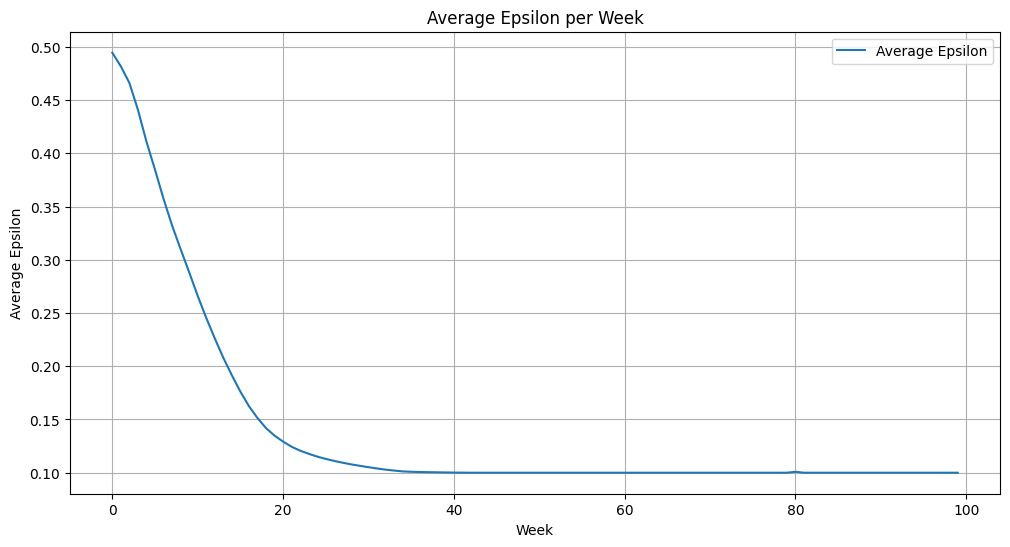

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(WEEKS), epsilon_tracking, label='Average Epsilon')
plt.title('Average Epsilon per Week')
plt.xlabel('Week')
plt.ylabel('Average Epsilon')
plt.grid()
plt.legend()
plt.show()

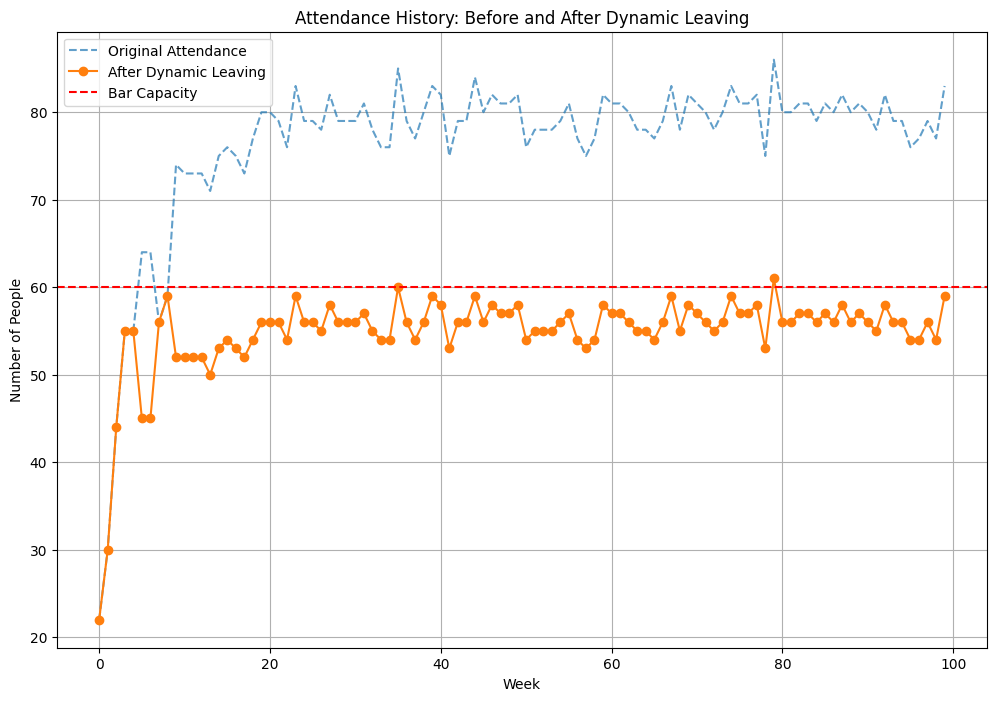

In [ ]:

# Plot attendance history with and without dynamic leaving
plt.figure(figsize=(12, 8))
plt.plot(range(WEEKS), raw_attendance[:WEEKS], label='Original Attendance', linestyle='--', alpha=0.7)
plt.plot(range(WEEKS), history[-WEEKS:], label='After Dynamic Leaving', marker='o')
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')
plt.title('Attendance History: Before and After Dynamic Leaving')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("BAR_CAPACITY:", BAR_CAPACITY)
print("N_AGENTS:", N_AGENTS)
print("SEQUENCE_LENGTH:", SEQUENCE_LENGTH)
print("WEEKS:", WEEKS)
print("Current Week:", week)
print("Attendance:", attendance)
print("Decisions:", decisions)
print("Predictions:", predictions)
print("History:", history)
print("Reward:", reward)

BAR_CAPACITY: 60
N_AGENTS: 100
SEQUENCE_LENGTH: 300
WEEKS: 100
Current Week: 99
Attendance: 59
Decisions: [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1]
Predictions: [0.21859805, -0.3923517, -0.43911844, 0.34448007, -0.0747931, -0.6323195, 0.7360732, 0.15592729, -1.3435674, -0.3071298, 0.28276587, 0.5491038, 0.065532036, -0.90320903, -0.071540244, 0.25099358, -0.5587179, -0.544964, -0.05681733, -0.94149274, 0.5776779, -0.13259111, -0.4289389, -0.27488938, -0.3473449, 1.3896371, -0.42389077, -0.14125127, -0.37298083, -0.18049024, -0.06500653, -0.6892598, -0.3998223, -0.9178112, 0.85366875, 0.7463698, -0.49077109, -0.3390978, 1.3960878, -0.85808027, 0.81607217, -0.41332597, -0.13916518, -0.24297157, 0.54118234, 0.92765635, -0.409308, -0.3

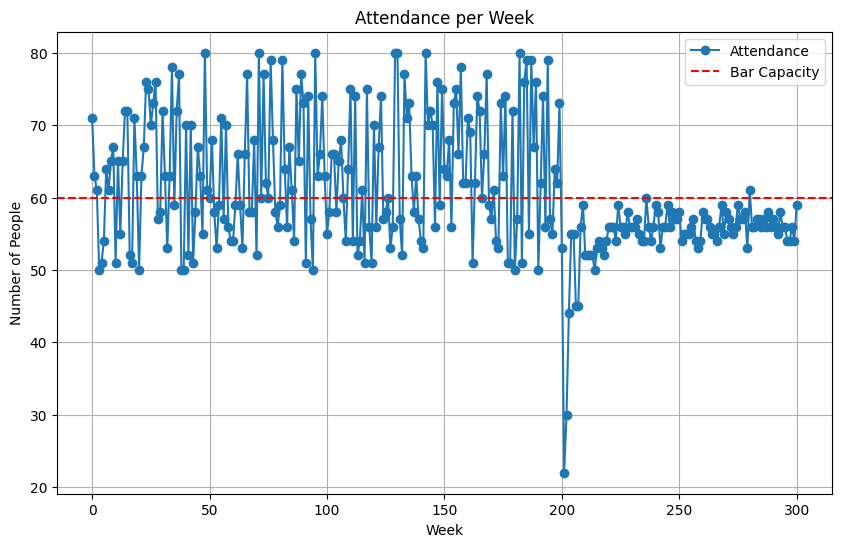

In [ ]:
import matplotlib.pyplot as plt

# Plot attendance history
plt.figure(figsize=(10, 6))
plt.plot(range(len(history)), history, marker='o', label='Attendance')
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')
plt.title('Attendance per Week')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from collections import Counter

# Count the frequency of attendance values
attendance_frequency = Counter(history)

# Display the frequency
print("Attendance Frequency per Week:")
for attendance_value, frequency in sorted(attendance_frequency.items()):
    print(f"Attendance: {attendance_value}, Frequency: {frequency}")

Attendance Frequency per Week:
Attendance: 22, Frequency: 1
Attendance: 30, Frequency: 1
Attendance: 44, Frequency: 1
Attendance: 45, Frequency: 2
Attendance: 50, Frequency: 8
Attendance: 51, Frequency: 11
Attendance: 52, Frequency: 10
Attendance: 53, Frequency: 12
Attendance: 54, Frequency: 22
Attendance: 55, Frequency: 17
Attendance: 56, Frequency: 37
Attendance: 57, Frequency: 22
Attendance: 58, Frequency: 19
Attendance: 59, Frequency: 14
Attendance: 60, Frequency: 7
Attendance: 61, Frequency: 7
Attendance: 62, Frequency: 6
Attendance: 63, Frequency: 12
Attendance: 64, Frequency: 5
Attendance: 65, Frequency: 5
Attendance: 66, Frequency: 7
Attendance: 67, Frequency: 6
Attendance: 68, Frequency: 5
Attendance: 69, Frequency: 1
Attendance: 70, Frequency: 7
Attendance: 71, Frequency: 5
Attendance: 72, Frequency: 7
Attendance: 73, Frequency: 6
Attendance: 74, Frequency: 7
Attendance: 75, Frequency: 6
Attendance: 76, Frequency: 5
Attendance: 77, Frequency: 6
Attendance: 78, Frequency: 2
At

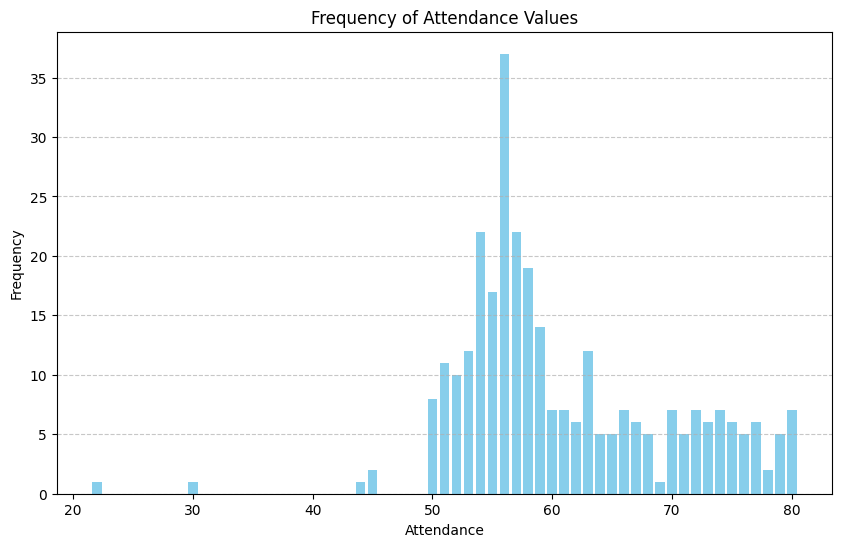

In [ ]:
# Visualize the frequency of attendance values
plt.figure(figsize=(10, 6))
plt.bar(attendance_frequency.keys(), attendance_frequency.values(), color='skyblue')
plt.title('Frequency of Attendance Values')
plt.xlabel('Attendance')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


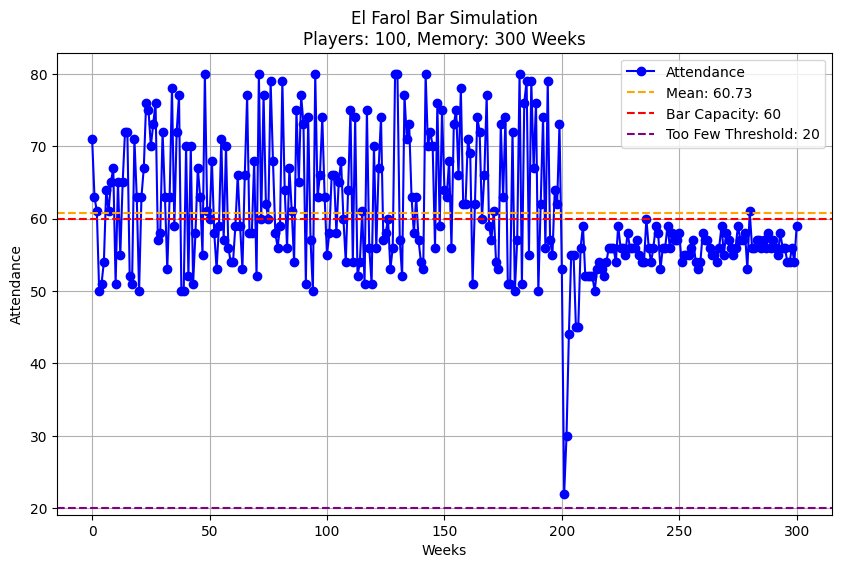

In [ ]:
# Calculate the mean attendance
mean_data = np.mean(history)

# Plot the attendance history, mean, bar capacity, and too few threshold
plt.figure(figsize=(10, 6))
plt.plot(history, label='Attendance', marker='o', color='blue')
plt.axhline(y=mean_data, color='orange', linestyle='--', label='Mean: ' + str(round(mean_data, 2)))
plt.axhline(y=BAR_CAPACITY, color='red', linestyle='--', label='Bar Capacity: ' + str(BAR_CAPACITY))
plt.axhline(y=TOO_FEW, color='purple', linestyle='--', label='Too Few Threshold: ' + str(TOO_FEW))
plt.legend()
plt.xlabel("Weeks")
plt.ylabel("Attendance")
plt.grid()
plt.title("El Farol Bar Simulation\nPlayers: " + str(N_AGENTS) + ", Memory: " + str(SEQUENCE_LENGTH) + " Weeks")
plt.show()

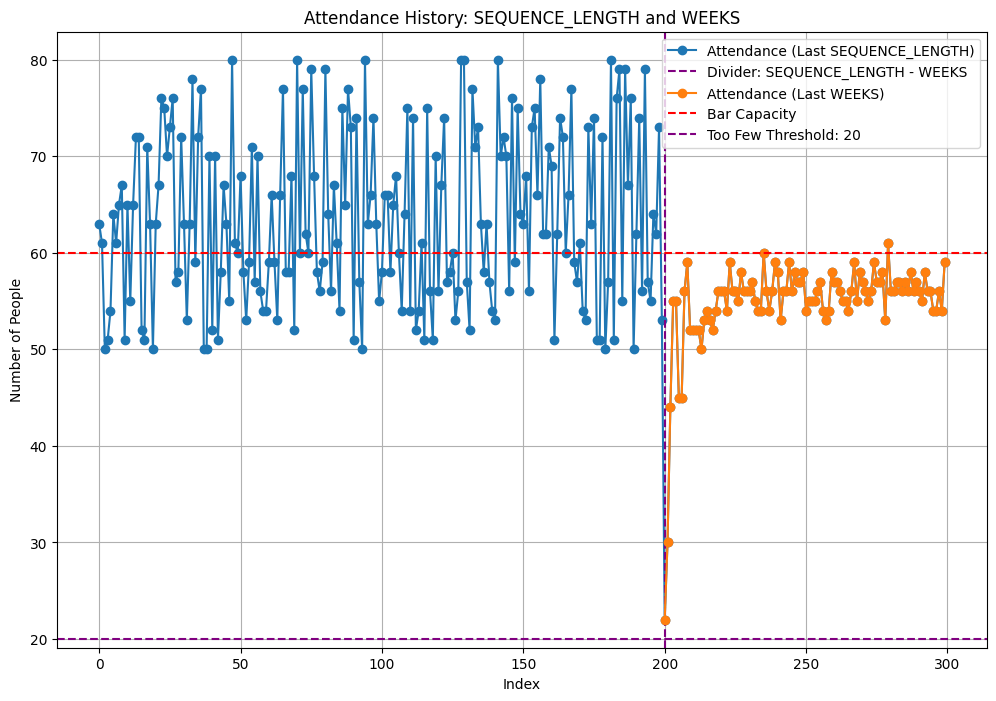

In [ ]:
# Plot attendance history for SEQUENCE_LENGTH and WEEKS
plt.figure(figsize=(12, 8))

# Plot data for SEQUENCE_LENGTH
plt.plot(range(SEQUENCE_LENGTH), history[-SEQUENCE_LENGTH:], marker='o', label='Attendance (Last SEQUENCE_LENGTH)')

# Add a divider label
plt.axvline(x=SEQUENCE_LENGTH - WEEKS, color='purple', linestyle='--', label='Divider: SEQUENCE_LENGTH - WEEKS')

# Plot data for WEEKS
plt.plot(range(SEQUENCE_LENGTH - WEEKS, SEQUENCE_LENGTH), history[-WEEKS:], marker='o', label='Attendance (Last WEEKS)')

# Add labels and legend
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')
plt.axhline(y=TOO_FEW, color='purple', linestyle='--', label='Too Few Threshold: ' + str(TOO_FEW))
plt.title('Attendance History: SEQUENCE_LENGTH and WEEKS')
plt.xlabel('Index')
plt.ylabel('Number of People')
plt.legend()
plt.grid()
plt.show()

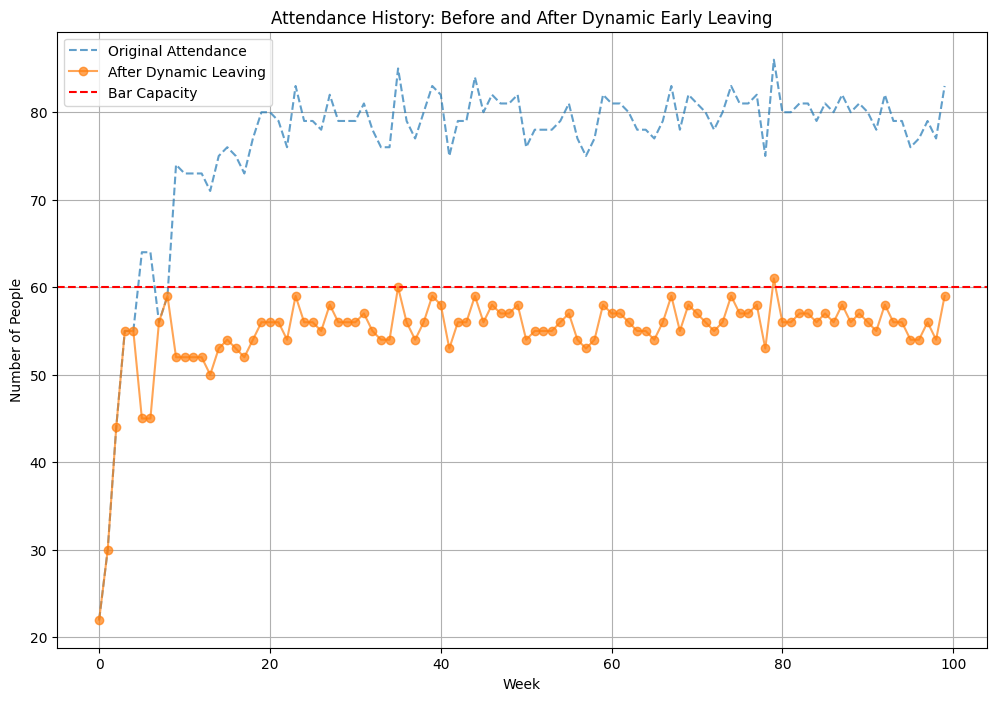

In [ ]:
plt.figure(figsize=(12, 8))

# Plot original attendance (before dynamic early leaving)
plt.plot(range(WEEKS), raw_attendance, label='Original Attendance', linestyle='--', alpha=0.7)

# Plot attendance after applying early leaving
plt.plot(range(WEEKS), history[-WEEKS:], label='After Dynamic Leaving', marker='o', alpha=0.7)

# Bar capacity line
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')

plt.title('Attendance History: Before and After Dynamic Early Leaving')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
for idx, agent in enumerate(agents):
    print(f"Agent {idx}:")
    print(f"  Q-Table: {agent.q_table}")
    print(f"  Epsilon: {agent.epsilon}")
    print(f"  Past Attendance: {agent.past_attendance}")
    print()

Agent 0:
  Q-Table: [ 1.09651019 14.76392758]
  Epsilon: 0.1
  Past Attendance: [74, 64, 79, 68, 64, 65, 53, 61, 76, 66, 57, 68, 60, 74, 72, 76, 78, 65, 53, 58, 72, 66, 78, 74, 69, 72, 55, 53, 72, 51, 56, 75, 60, 61, 65, 68, 60, 71, 78, 59, 66, 70, 52, 72, 75, 59, 56, 61, 60, 57, 79, 72, 57, 79, 72, 70, 51, 51, 55, 67, 56, 57, 77, 61, 67, 54, 66, 80, 80, 74, 80, 59, 78, 57, 80, 66, 71, 55, 51, 60, 57, 62, 64, 51, 69, 58, 53, 55, 78, 60, 56, 77, 51, 54, 74, 51, 50, 78, 60, 63, 53, 54, 79, 51, 64, 79, 78, 58, 74, 70, 72, 76, 74, 76, 69, 78, 50, 55, 59, 66, 75, 64, 73, 65, 77, 57, 65, 55, 62, 56, 51, 73, 79, 80, 57, 68, 67, 63, 59, 64, 66, 73, 80, 70, 77, 63, 64, 60, 70, 61, 71, 62, 69, 79, 70, 60, 56, 73, 77, 63, 56, 74, 71, 50, 76, 56, 56, 56, 59, 51, 60, 56, 72, 54, 72, 51, 61, 55, 57, 50, 75, 64, 80, 68, 50, 80, 71, 58, 64, 76, 65, 55, 64, 54, 67, 70, 52, 58, 75, 75, 78, 22, 30, 44, 55, 55, 45, 45, 56, 59, 52, 52, 52, 52, 50, 53, 54, 53, 52, 54, 56, 56, 56, 54, 59, 56, 56, 55, 58, 56,

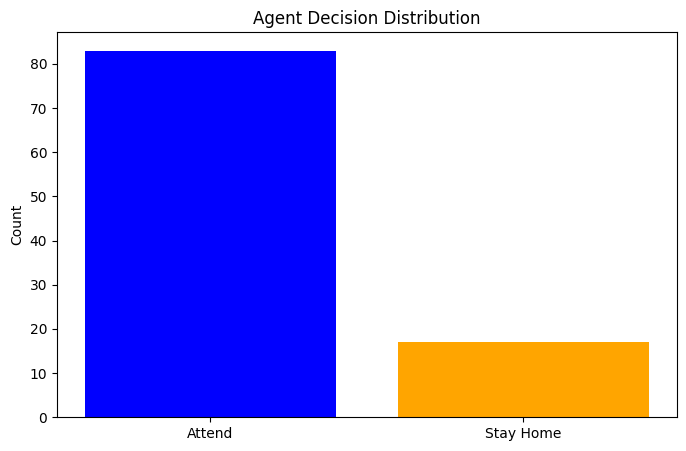

In [ ]:
decisions_count = [sum(decisions), len(decisions) - sum(decisions)]
plt.figure(figsize=(8, 5))
plt.bar(['Attend', 'Stay Home'], decisions_count, color=['blue', 'orange'])
plt.title('Agent Decision Distribution')
plt.ylabel('Count')
plt.show()

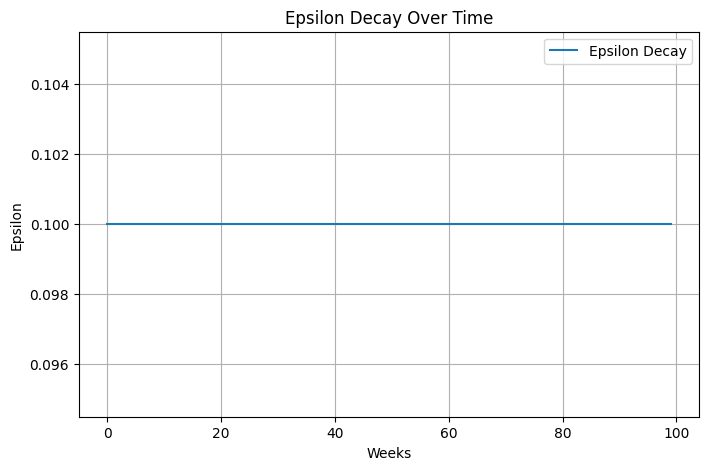

In [ ]:
epsilon_values = [agent.epsilon for agent in agents]
plt.figure(figsize=(8, 5))
plt.plot(range(len(epsilon_values)), epsilon_values, label='Epsilon Decay')
plt.title('Epsilon Decay Over Time')
plt.xlabel('Weeks')
plt.ylabel('Epsilon')
plt.grid()
plt.legend()
plt.show()

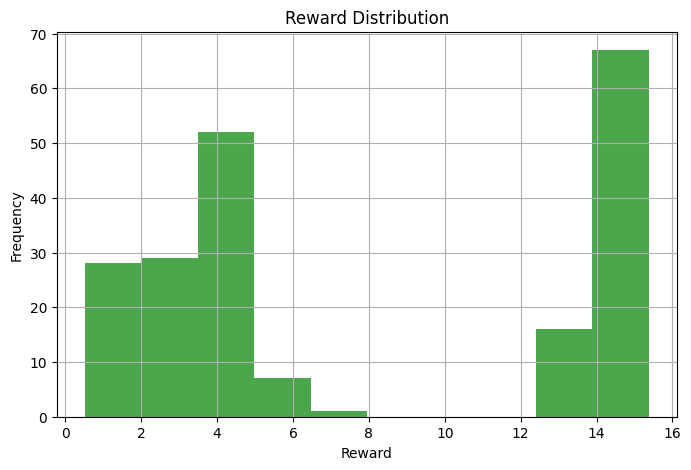

In [ ]:
rewards = [reward for agent in agents for reward in agent.q_table]
plt.figure(figsize=(8, 5))
plt.hist(rewards, bins=10, color='green', alpha=0.7)
plt.title('Reward Distribution')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.grid()
plt.show()

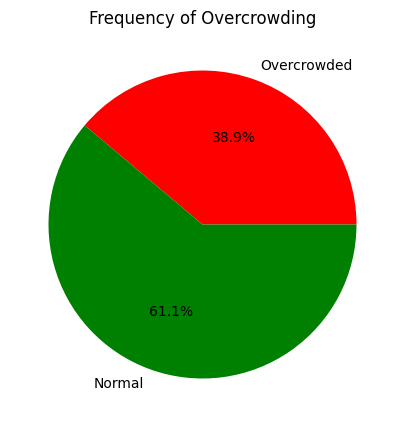

In [ ]:
overcrowded_weeks = sum(1 for a in history if a > BAR_CAPACITY)
normal_weeks = len(history) - overcrowded_weeks
plt.figure(figsize=(8, 5))
plt.pie([overcrowded_weeks, normal_weeks], labels=['Overcrowded', 'Normal'], autopct='%1.1f%%', colors=['red', 'green'])
plt.title('Frequency of Overcrowding')
plt.show()

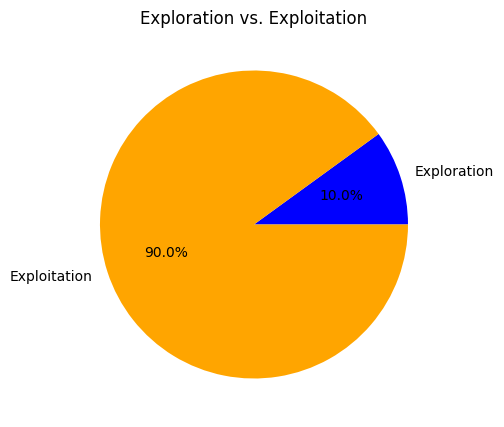

In [ ]:
exploration_count = sum(1 for agent in agents if random.random() < agent.epsilon)
exploitation_count = len(agents) - exploration_count
plt.figure(figsize=(8, 5))
plt.pie([exploration_count, exploitation_count], labels=['Exploration', 'Exploitation'], autopct='%1.1f%%', colors=['blue', 'orange'])
plt.title('Exploration vs. Exploitation')
plt.show()

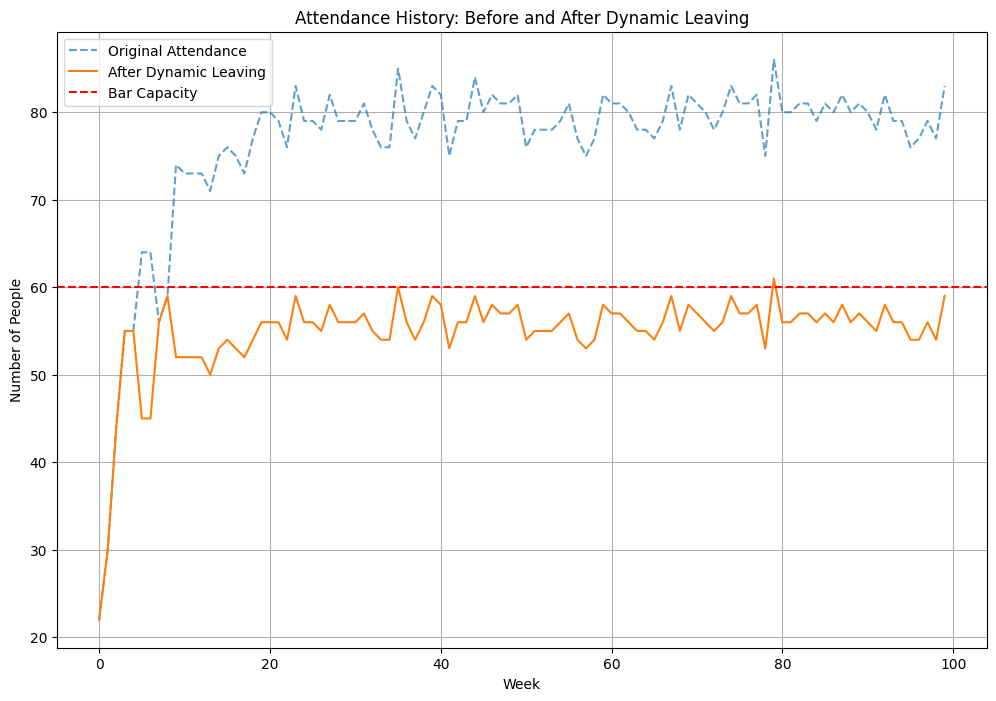

In [ ]:
# Plot attendance history with and without dynamic leaving
plt.figure(figsize=(12, 8))
plt.plot(range(WEEKS), raw_attendance[:WEEKS], label='Original Attendance', linestyle='--', alpha=0.7)
plt.plot(range(WEEKS), history[-WEEKS:], label='After Dynamic Leaving')
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')
plt.title('Attendance History: Before and After Dynamic Leaving')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.grid()
plt.show()